In [23]:
using Pkg
TAMBOPATH = "/Users/jlazar/research/TAMBO-MC/"
Pkg.activate("$(TAMBOPATH)/Tambo/")
using Tambo

  Activating project at `~/research/TAMBO-MC/Tambo`


In [24]:
using JLD2
include("../paperstyle.jl")
using Roots

In [25]:
f = jldopen("/Users/jlazar/Downloads/example.jld2")

JLDFile /Users/jlazar/Downloads/example.jld2 (read-only)
 ├─🔢 τ_res
 ├─🔢 τ
 ├─🔢 μ_res
 └─🔢 μ

In [26]:
simulation_config = Tambo.SimulationConfig()
geo = Tambo.Geometry(simulation_config);

In [27]:
xs = LinRange(geo.box.c1.x, geo.box.c2.x, 500)
ys = LinRange(geo.box.c1.y, geo.box.c2.y, 550)
zs = reshape([geo(x,y) for x in xs for y in ys], (550, 500));

In [28]:
τ = f["τ"]
τ_res = f["τ_res"]
τ_track_0 = reverse(Tambo.Track(τ.position, reverse(τ.direction), geo.box))
τ_track_1 = Tambo.Track(τ.position, τ_res.propped_state.position)

μ = f["μ"]
μ_res = f["μ_res"]
μ_track_0 = reverse(Tambo.Track(μ.position, reverse(μ.direction), geo.box))
μ_track_1 = Tambo.Track(μ.position, μ_res.propped_state.position)

Tambo.Track{Float64}([-2.365863965415602e10, 1.5657718662563416e10, 1.5042220162258244e9], [1.385852815511451e10, -6.002828271351313e9, -1.0981672326877997e9], (93.4°, 330.0°), 4.339918897523488e10)

In [29]:
function energy_lost(λ, res, λs)
    m = λ .> λs
    stocastic_lost = 0.0
    if sum(m) > 0
        stocastic_lost = sum(getfield.(res.stochastic_losses[m], :energy))
    end
    continuous_lost = λ * res.continuous_losses.energy
    return continuous_lost + stocastic_lost
end

getfield.(τ_res.stochastic_losses, :energy)
τ_λs = Float64[]
for loss in τ_res.stochastic_losses
    z = loss.position.z
    plz(λ) = τ_track_1(λ).z - z
    λ0 = find_zero(plz, (0, 1))
    push!(τ_λs, λ0)
end

getfield.(μ_res.stochastic_losses, :energy)
μ_λs = Float64[]
for loss in μ_res.stochastic_losses
    z = loss.position.z
    plz(λ) = μ_track_1(λ).z - z
    λ0 = find_zero(plz, (0, 1))
    push!(μ_λs, λ0)
end

In [30]:
μ_zs = (getindex.(μ_track_1.(LinRange(0, 1, 100)), 3) .+ μ_track_0.norm) / units.km

100-element Vector{Float64}:
 17.365679558162835
 17.360492471394675
 17.35530538462651
 17.350118297858355
 17.34493121109019
 17.33974412432203
 17.33455703755387
 17.32936995078571
 17.32418286401755
 17.31899577724939
 17.313808690481228
 17.30862160371307
 17.303434516944908
  ⋮
 16.909215922564716
 16.904028835796556
 16.898841749028396
 16.893654662260236
 16.888467575492076
 16.883280488723916
 16.878093401955756
 16.872906315187596
 16.867719228419432
 16.862532141651275
 16.857345054883112
 16.852157968114952

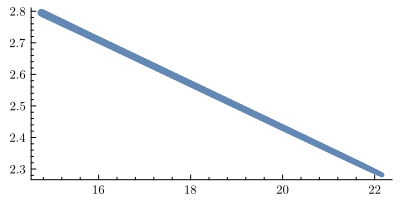

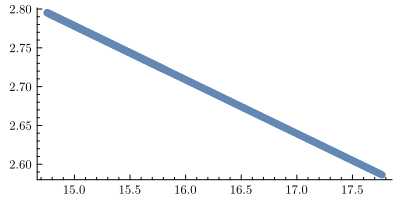

In [47]:
plt = plot(μ_xs, μ_zs, lw=log.(10, μ_es))
display(plt)
plt = plot(τ_xs, τ_zs, lw=log.(10, τ_es))
display(plt)

In [46]:
big_track = Tambo.Track(τ_track_0(0.00001), τ.direction, geo.box)

ν_ds = [0, μ_track_0.norm / units.km]
ν_xs = (getindex.(τ_track_0.(LinRange(0, 1, 2)), 1) .+ geo.tambo_offset.z) / units.km
ν_ys = (getindex.(τ_track_0.(LinRange(0, 1, 2)), 2) .+ geo.tambo_offset.z) / units.km
ν_zs = (getindex.(τ_track_0.(LinRange(0, 1, 2)), 3) .+ geo.tambo_offset.z)/ units.km
ν_es = [μ.energy/units.GeV, μ.energy / units.GeV]

τ_ds = (LinRange(0, 1, 100) .* τ_track_1.norm .+ τ_track_0.norm) / units.km
τ_xs = (getindex.(τ_track_1.(LinRange(0, 1, 100)), 1) .+ geo.tambo_offset.x) / units.km
τ_ys = (getindex.(τ_track_1.(LinRange(0, 1, 100)), 2) .+ geo.tambo_offset.y) / units.km
τ_zs = (getindex.(τ_track_1.(LinRange(0, 1, 100)), 3) .+ geo.tambo_offset.z) / units.km
τ_es = (τ.energy .- energy_lost.(LinRange(0,1,100), Ref(τ_res), Ref(τ_λs))) ./units.GeV

μ_ds = (LinRange(0, 1, 100) .* μ_track_1.norm .+ μ_track_0.norm) / units.km
μ_xs = (getindex.(μ_track_1.(LinRange(0, 1, 100)), 1) .+ geo.tambo_offset.x) / units.km
μ_ys = (getindex.(μ_track_1.(LinRange(0, 1, 100)), 2) .+ geo.tambo_offset.y) / units.km
μ_zs = (getindex.(μ_track_1.(LinRange(0, 1, 100)), 3) .+ geo.tambo_offset.z) / units.km
μ_es = (μ.energy .- energy_lost.(LinRange(0,1,100), Ref(μ_res), Ref(μ_λs))) ./units.GeV

mountain_xs = LinRange(0,1,1000) * big_track.norm ./ units.km
mountain_ys = (geo.(getindex.(big_track.(LinRange(0,1,1000)), 1), getindex.(big_track.(LinRange(0,1,1000)), 2)) .+ geo.tambo_offset.z) ./ units.km

1000-element Vector{Float64}:
 4.864632326115803
 4.952765264350944
 5.009401364111663
 5.034877974760038
 5.0306315283210985
 4.999137597375413
 4.943820528270783
 4.868932649653034
 4.779403056315842
 4.680655968369692
 4.578398665729888
 4.478378997923661
 4.386112469216357
 ⋮
 4.27196992933817
 4.276322419790778
 4.282105426120092
 4.288988603784075
 4.296617507884646
 4.3046238752758335
 4.312635805485055
 4.320287840447519
 4.327230943053745
 4.33314230211706
 4.337723768834641
 4.340695711189455

In [33]:
μ_color = :pink
τ_color = :red


:red

## Altitude map

In [55]:
alt_plt = plot()
plot!(alt_plt, mountain_xs, mountain_ys, color=:peru)
plot!(alt_plt, ν_ds, ν_zs, ls=:dash, color=:white, lw=lw0, label=L"\nu_{\alpha}")
plot!(alt_plt, τ_ds, τ_zs, color=τ_color, lw=lw0 .* τ_es ./ ν_es[1], label=L"\tau^{-}")
plot!(alt_plt, μ_ds, μ_zs, color=μ_color, lw=lw0 .* μ_es ./ ν_es[1], label=L"\mu^{-}")
plot!(
    alt_plt,
    xlims=(10,25),
    xlabel=L"d_{\mathrm{prop}}",
    ylim=(1.7,5.5),
    ylabel="Altitude [km]",
    bg_legend = :transparent,
    
)
no_bg_dark!(alt_plt)
savefig(alt_plt, "/Users/jlazar/research/TAMBO-MC/figures/altitude_transparent.svg")

"/Users/jlazar/research/TAMBO-MC/figures/altitude_transparent.svg"

## Energy plot

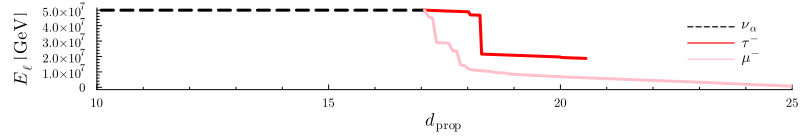

In [35]:
energy_plt = plot(size=(800,140), bottommargin=7mm, leftmargin=7mm)
plot!(energy_plt, ν_ds, ν_es, color=:black, ls=:dash, lw=3, label=L"\nu_{\alpha}")
plot!(energy_plt, τ_ds, τ_es, color=τ_color, label=L"\tau^{-}", lw=3)
plot!(energy_plt, μ_ds, μ_es, color=μ_color, label=L"\mu^{-}", lw=3)
plot!(
    energy_plt,
    xlims=(10,25),
    xlabel=L"d_{\mathrm{prop}}",
    ylabel=L"E_{\ell}~\left[\mathrm{GeV}\right]",
    xlabelfontsize=12,
    ylabelfontsize=12,
    ticklabelfontsize=12
)


In [36]:
ds = plot(alt_plt, energy_plt, size=(800, 270), layout=(2,1))
savefig(ds, "bottomplot.pdf")

"/Users/jlazar/research/TAMBO-MC/notebooks/bottomplot.pdf"

## $\mu$ map

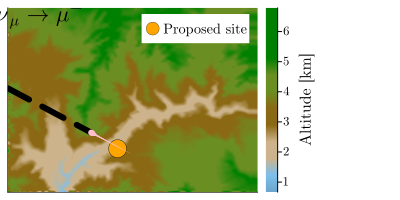

In [37]:
c = cgrad(palette([:skyblue3, :skyblue2, :navajowhite3, :navajowhite3, :goldenrod4, :goldenrod4, :olivedrab, :olivedrab, :green, :green, :green, :green]))
hm_μ = heatmap(
    xs / units.km,
    ys / units.km,
    (zs.+geo.tambo_offset.z) / units.km,
    c=c,
    # legend=:none,
    rightmargin=20mm,
    legendfontsize=9,
    xticks=:none,
    yticks=:none,
    colorbar_title="Altitude [km]"
    
)

scatter!(hm_μ, [0], [0], label="Proposed site", markersize=10, color=:orange)

lw0 = 6
plot!(
    hm_μ,
    getindex.(μ_track_0.(LinRange(0, 1, 100)), 1) ./ units.km,
    getindex.(μ_track_0.(LinRange(0, 1, 100)), 2) ./ units.km,
    ls=:dash,
    color=:black,
    lw=lw0
)

plot!(
    hm_μ,
    getindex.(μ_track_1.(LinRange(0, 1, 100)), 1) ./ units.km,
    getindex.(μ_track_1.(LinRange(0, 1, 100)), 2) ./ units.km,
    color=μ_color,
    lw=lw0 .* μ_es ./ ν_es[1]
)

plot!(
    hm_μ,
    annotations=(-13.5, 25 , L"\nu_{\mu}\rightarrow\mu^{-}"),
    annotationfontsize=15
)

xlims!(hm_μ, xs[1] / units.km, xs[end] / units.km)
ylims!(hm_μ, ys[1] / units.km, ys[end] / units.km)
display(hm_μ)

## $\tau$ map

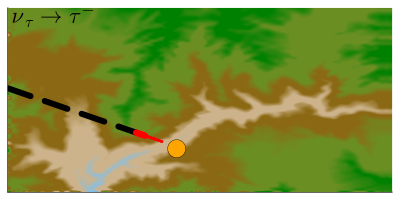

In [38]:
c = cgrad(palette([:skyblue3, :skyblue2, :navajowhite3, :navajowhite3, :goldenrod4, :goldenrod4, :olivedrab, :olivedrab, :green, :green, :green, :green]))
hm_τ = heatmap(
    xs / units.km,
    ys / units.km,
    (zs.+geo.tambo_offset.z) / units.km,
    c=c,
    yticks=:none,
    xticks=:none,
    legend=:none,
    # leftmargin=2mm,
)

scatter!(hm_τ, [0], [0], markersize=10, color=:orange)

plot!(
    hm_τ,
    getindex.(μ_track_0.(LinRange(0, 1, 100)), 1) ./ units.km,
    getindex.(μ_track_0.(LinRange(0, 1, 100)), 2) ./ units.km,
    ls=:dash,
    color=:black,
    lw = lw0
    
)

plot!(
    hm_τ,
    getindex.(τ_track_1.(LinRange(0, 1, 100)), 1) ./ units.km,
    getindex.(τ_track_1.(LinRange(0, 1, 100)), 2) ./ units.km,
    color=τ_color,
    lw=lw0 .* τ_es ./ ν_es[1]
)

plot!(
    hm_τ,
    annotations=(-14, 25 , L"\nu_{\tau}\rightarrow\tau^{-}"),
    annotationfontsize=15
)

xlims!(hm_τ, xs[1] / units.km, xs[end] / units.km)
ylims!(hm_τ, ys[1] / units.km, ys[end] / units.km)
plot!()
display(hm_τ)

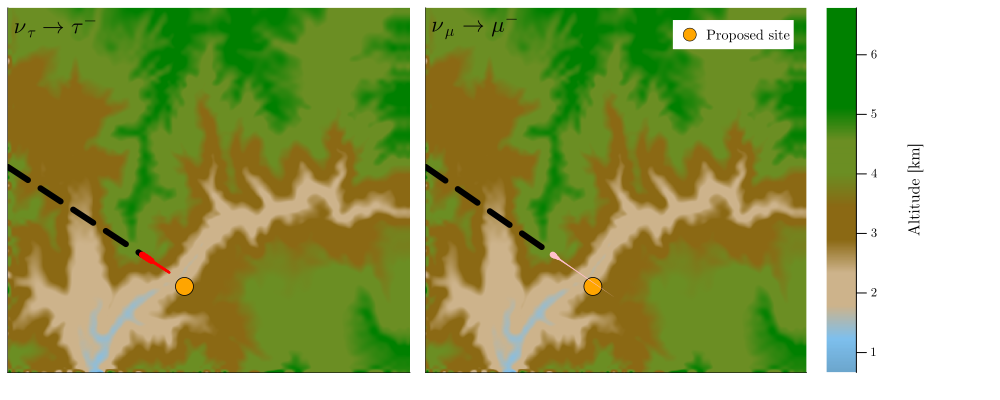

In [39]:
l = @layout [
    a{0.46w} b{0.55w}
]
hms = plot(hm_τ, hm_μ, size=(1000, 400), bottommargin=5mm, layout=l)
savefig(hms, "heatmaps.pdf")
display(hms)

In [40]:
plot!(alt_plt, xlabel=L"d_{\mathrm{prop}}")
savefig(alt_plt, "altitude.pdf")

"/Users/jlazar/research/TAMBO-MC/notebooks/altitude.pdf"

In [41]:
simulation = jldopen("/Users/jlazar/Downloads/simulation.j2")

JLDFile /Users/jlazar/Downloads/simulation.j2 (read-only)
 ├─🔢 injected_events
 ├─🔢 proposal_events
 └─🔢 config

In [42]:
injection_events = simulation["injected_events"];

┌ Warning: saved type InjectionEvent is missing field physX in workspace type; reconstructing
└ @ JLD2 /Users/jlazar/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:152


LoadError: MethodError: [0mCannot `convert` an object of type [92mJLD2.ReconstructedTypes.var"##InjectionEvent#318"[39m[0m to an object of type [91mInjectionEvent[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T at Base.jl:61
[0m  InjectionEvent(::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at ~/research/TAMBO-MC/Tambo/src/inject.jl:90